<a href="https://colab.research.google.com/github/CamilleGreen5/Deep_Learning_with_Python/blob/master/Hyperas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pydub
!pip install hyperas

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import glob
import datetime
import os
import cv2 as cv
from scipy.io.wavfile import read, write
from scipy.signal import stft, istft
from pydub import AudioSegment
from tensorflow.keras import models, layers
from tqdm.notebook import tqdm

## **HYPERAS**

In [ ]:
from __future__ import print_function
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform, conditional

In [ ]:
def data():
    '''
    Data providing function:

    Make sure to have every relevant import statement included here and return data as
    used in model function below. This function is separated from model() so that hyperopt
    won't reload data for each evaluation run.
    '''
    from keras.datasets import mnist
    from keras.utils import np_utils
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train = X_train.reshape(60000, 784)
    X_test = X_test.reshape(10000, 784)
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255
    X_test /= 255
    nb_classes = 10
    Y_train = np_utils.to_categorical(y_train, nb_classes)
    Y_test = np_utils.to_categorical(y_test, nb_classes)
    return X_train, Y_train, X_test, Y_test

In [ ]:
def model(X_train, Y_train, X_test, Y_test):
    '''
    Model providing function:

    Create Keras model with double curly brackets dropped-in as needed.
    Return value has to be a valid python dictionary with two customary keys:
        - loss: Specify a numeric evaluation metric to be minimized
        - status: Just use STATUS_OK and see hyperopt documentation if not feasible
    The last one is optional, though recommended, namely:
        - model: specify the model just created so that we can later use it again.
    '''
    from keras.models import Sequential
    from keras.layers.core import Dense, Dropout, Activation

    model = Sequential()
    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation('relu'))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Dense({{choice([256, 512, 1024])}}))
    model.add(Activation({{choice(['relu', 'sigmoid'])}}))
    model.add(Dropout({{uniform(0, 1)}}))

    # If we choose 'four', add an additional fourth layer
    if conditional({{choice(['three', 'four'])}}) == 'four':
        model.add(Dense(100))
        # We can also choose between complete sets of layers
        model.add({{choice([Dropout(0.5), Activation('linear')])}})
        model.add(Activation('relu'))

    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer={{choice(['rmsprop', 'adam', 'sgd'])}})

    model.fit(X_train, Y_train,
              batch_size={{choice([64, 128])}},
              nb_epoch=1,
              show_accuracy=True,
              verbose=2,
              validation_data=(X_test, Y_test))
    score, acc = model.evaluate(X_test, Y_test, show_accuracy=True, verbose=0)
    print('Test accuracy:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [ ]:
best_run, best_model = optim.minimize(model=model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=5,
                                      trials=Trials())
X_train, Y_train, X_test, Y_test = data()
print("Evalutation of best performing model:")
print(best_model.evaluate(X_test, Y_test))

## **TEST**

In [ ]:
def load_and_convert_data(train_mp3_data, add_noise_to_sample=False):
    """
    function to load mp3 data, only the sample, and convert it to array, then to f-t-domain
    -- train_mp3_data : list of mp3 data to load
    -- add_noise_to_sample : True/False indicate if noise has to be added
    -- return : abs and im part of the sample, some characteristic of the sample
    """
    samples = []
    im_samples = []
    i = 0

    for path_to_mp3_file in tqdm(train_mp3_data):

        # load mp3 sound to array
        loaded_sound = AudioSegment.from_mp3(path_to_mp3_file)
        array_sound = np.array(loaded_sound.get_array_of_samples(), np.float64)

        len_arr = len(array_sound)

        plt.plot([i for i in range(len(array_sound))], array_sound, 'b')
        plt.show()

        # normalize array
        mean = np.mean(array_sound, axis=0)
        array_sound -= mean

        if add_noise_to_sample:
            array_sound = add_noise(array_sound)
            # save reconverted sound to wav
            path_to_wav_file = './noisy_sound0.wav'
            write(path_to_wav_file, 48000, array_sound)

        max_arr = np.max(np.abs(array_sound))
        array_sound = np.array(array_sound/max_arr, np.float32)

        # convert sample to to F_T_space
        f, t, array_stft = stft(array_sound, fs=48000, nperseg=1000)
        sample_abs_stft = np.abs(array_stft)
        sample_im_stft = np.imag(array_stft)

        # padding 
        pad_length = 1000 - np.shape(sample_abs_stft)[1]
        sample_abs_stft = np.pad(sample_abs_stft, ((0,0), (0, pad_length)))
        sample_im_stft = np.pad(sample_im_stft, ((0,0), (0, pad_length)))

        samples.append(sample_abs_stft)
        im_samples.append(sample_im_stft)
        i+=1

    samples = np.array(samples)
    im_samples = np.array(im_samples)

    return samples, im_samples, mean, max_arr, len_arr

In [ ]:
def add_noise(array_sound):
    """
    function to add gaussian noise to an array
    -- array_sound : array which to add noise
    -- return : the noisy array
    """
    max_1 = np.max(array_sound)
    noise = np.random.normal(0, 0.02*max_1, len(array_sound))
    array_sound_noisy = np.add(noise, array_sound)
    max_2 = np.max(array_sound_noisy)
    array_sound_noisy = (array_sound_noisy*max_1)//max_2

    return np.array(array_sound_noisy, np.int16)

In [ ]:
def denoising(samples, imag_samples, mean, max_arr, len_arr):
    """
    function to denoise data by loading the model, predict and convert back to array of sound
    -- samples : sample to denoise
    -- imag_samples : im part of the sample to denoise
    -- some characteristics of the sample
    -- return : the denoised array
    """
    # load model
    model = tf.keras.models.load_model('./mymodel.h5')

    # reshape data
    samples = np.squeeze(samples)
    imag_samples = np.squeeze(imag_samples)
    samples = np.transpose(samples)
    imag_samples = np.transpose(imag_samples)
    samples = np.expand_dims(samples, axis=0)
    imag_samples = np.expand_dims(imag_samples, axis=0)
    samples = np.expand_dims(samples, axis=-1)
    imag_samples = np.expand_dims(imag_samples, axis=-1)
    # print(np.shape(samples))

    # predict
    denoised_samples = model.predict(samples)

    denoised_samples = np.transpose(denoised_samples)
    imag_samples = np.transpose(imag_samples)

    # print(np.shape(denoised_samples))

    # plt.pcolormesh(denoised_samples[:len_arr,:])
    # plt.title('STFT denoised Magnitude')
    # plt.ylabel('Frequency [Hz]')
    # plt.xlabel('Time [sec]')
    # plt.show()

    denoised_stft = denoised_samples + 1j*imag_samples
    denoised_stft = np.squeeze(denoised_stft)
    # print(np.shape(denoised_stft))

    # convert back to sound from F_T_space
    t, desnoised_array_sound = istft(denoised_stft, fs=48000, nperseg=1000)
    desnoised_array_sound = np.array(desnoised_array_sound)
    desnoised_array_sound *= max_arr
    desnoised_array_sound += mean
    desnoised_array_sound = np.array(desnoised_array_sound, np.int16)

    return desnoised_array_sound


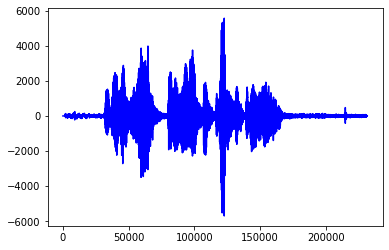


(231552,)


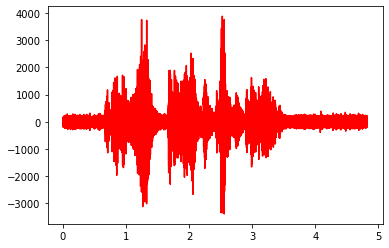

In [ ]:
# load a mp3 file, convert it to array and then to f-t-domain, add noise, predict the denoised array and save it

list_files = ["./common_voice_fr_18157595.mp3"]
samples, imag_samples, mean, max_arr, len_arr = load_and_convert_data(list_files, True)

denoised_array_sound = denoising(samples, imag_samples, mean, max_arr, len_arr)
# print(len_arr)
denoised_array_sound = denoised_array_sound[:len_arr]
print(np.shape(denoised_array_sound))

plt.plot([i/48000 for i in range(len_arr)], denoised_array_sound, 'r')
plt.show()

# print(np.shape(denoi sed_samples))
# samples, x = reshape_data(samples)
# samples = np.transpose(samples)
# samples = samples[:len_arr,:]

# print(np.shape(samples))
# print(np.shape(denoised_array_sound))

# plt.pcolormesh(samples)
# plt.title('STFT sample Magnitude')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.show()

# save reconverted sound to wav
path_to_wav_file = './denoised_sound0.wav'
write(path_to_wav_file, 48000, denoised_array_sound)
    